# Laboratorijska vaja: Zgodovinske šifre

Namen laboratorijske vaje se je spoznati z izbranimi zgodovinskimi šiframi, 
jih implementirati, nato pa jih tudi uspešno napasti. 

Podrobnosti posameznih šifer poiščite v prosojnicah s predavanj.

## Pomožne funkcije in spremenljivke

Za začetek v globalno spremenljivko `ALPHABET` zapišimo abecedo znakov. 
V našem primeru abeceda vsebuje male slovenske črke in presledek: primere bomo
poenostavili, tako da bomo izpuščali velike črke, števke, ločila in ostale znake.

Funkcija `normalize` filtrira poljuben niz in iz njega odstrani vse znake, ki niso
del naše abecede. Funkcija `valid_input` vrne `True`, če in samo če so vsi znaki v
podanem niz del naše abecede.

In [49]:
ALPHABET = 'abcčdefghijklmnoprsštuvzž '


def normalize(msg):
    msg = " ".join(msg.lower().split())
    return "".join(x for x in msg if x in ALPHABET)


def valid_input(data):
    return all(x in ALPHABET for x in data)

## Naloga 1: Zamična šifra

Pri zamični šifri znake besedila zamaknemo za toliko mest kot določa črka v ključu. Pri implementaciji si pomagajte z globalno spremenljivko `ALPHABET`.

Metoda `enc_shift(key, pt)` naj implementira šifrirni algoritem, metoda `dec_shift(key, ct)` pa dešifrirnega.

In [50]:
def enc_shift(key, pt):
    inx = ALPHABET.find(key)
    ct = ""
    for c in pt:
        ct += ALPHABET[(ALPHABET.index(c) + inx) % 26]
    return ct
        

In [51]:
assert enc_shift("a", "dober dan") == "dober dan"
assert enc_shift("b", "dober dan") == "epcfsaebo"
assert enc_shift("c", "dober dan") == "frčgšbfcp"
assert enc_shift("č", "dober dan") == "gsdhtcgčr"

In [52]:
def dec_shift(key, ct):
    inx = ALPHABET.find(key)
    pt = ""
    for z in ct:
        pt += ALPHABET[(ALPHABET.index(z) - inx) % 26]
    return pt

In [53]:
for key in ALPHABET:
    assert dec_shift(key, enc_shift(key, "pozdravljen svet")) == "pozdravljen svet"

## Naloga 2: Implementacija Vigenerjeve šifre

Implementirajte šifrirni in dešifrirni algoritem za Vigenerjevo šifro. Podrobnosti poiščite v prosojnicah s predavanj.

Namig: Implementacija je kratka, če  uporabite funkciji `enc_shift(k, pt)` ter `dec_shift(k, ct)`.


In [54]:
def enc_vigenere(key, pt):
    ct = ""
    for i, c in enumerate(pt):
        i_key = key[i % len(key)]
        ct += enc_shift(i_key, c)
    return ct
    

In [55]:
assert enc_vigenere("tajno", "dober dan") == "žokšfšdjc"
assert enc_vigenere("b", "dober dan") == enc_shift("b", "dober dan")

In [56]:
def dec_vigenere(key, ct):
    pt = ""
    for i, z in enumerate(ct):
        i_key = key[i % len(key)]
        pt += dec_shift(i_key, z)
    return pt

In [57]:
for k, pt in [("fri", "pozdravljen svet"), ("sladoled", "kratke hlače in natikači"), ("fleifnjvlauierhfdlejkfjsčawšžćčdqšfl", "kratek tajnopis")]:
    assert dec_vigenere(k, enc_vigenere(k, pt)) == pt

## Naloga 3: Implementacija zamenjalne šifre

Implementirajte algoritma šifriranja in dešifriranja za zamenjalno šifro. Pri zamenljalni šifri je ključ permutacija, ki pove, kako se znaki čistopisa zamenjajo z znaki tajnopisa. Kot primer je podan ključ $k$

$$k=\left(\begin{array}{}
a & b & c & \dots & ž & \_  \\
i & r & o & \dots & g & z \\
\end{array}\right)
$$

Ključ k zamenja črko `a` s črko `i`, črko `b` s črko `r` itd. Naravni način implementacije take permutacije s slovarjem. Funkcija `gen_substitution_key()` je primer funkcije, ki ustvari naključno permutacijo.

In [58]:
import random

def gen_substitution_key():
    return {p:c for p, c in zip(ALPHABET, random.sample(ALPHABET, len(ALPHABET)))}
    # ali še krajše:  dict(zip(ALPHABET, random.sample(ALPHABET, len(ALPHABET))))

In [59]:
def enc_substitution(key, pt):
    return "".join(key[c] for c in pt)

In [60]:
# Nekaj testov zamikalne šifre
k_subst = {
    'a': 'n', 'b': 'j', 'c': 'g', 'č': 'l', 'd': 'ž', 'e': 'c', 'f': 'u', 'g': 'k', 'h': 'p',
    'i': 'f', 'j': 'z', 'k': 'i', 'l': 'e', 'm': 't', 'n': 'š', 'o': 'm', 'p': ' ', 'r': 'b',
    's': 'r', 'š': 'v', 't': 'a', 'u': 'č', 'v': 'o', 'z': 's', 'ž': 'h', ' ': 'd'
}

assert enc_substitution(k_subst, "dober dan") == "žmjcbdžnš"
assert enc_substitution(k_subst, "lahko noč") == "enpimdšml"

In [61]:
def dec_substitution(key, ct):
    n_key = {p:c for c, p in key.items()}
    return "".join(n_key[z] for z in ct)

In [62]:
# Nekaj testov zamikalne šifre
for pt in ["dober dan", "dobro jutro", "lahko noč"]:
    k = gen_substitution_key()
    assert dec_substitution(k, enc_substitution(k, pt)) == pt

## Kriptoanaliza in napadi na zgodovinske šifre

Pri napadih na šifre bomo predpostavljali, da je šifrirana vsebina slovenska proza. Zato bomo najprej izračunali preprosto statistiko za tovrstna besedila. To bomo storili tako, da bomo (sicer zelo preprosto) statistično analizirali nekaj slovenskih besedil. Kot primer so izbrana štiri besedila iz slovenske zakonodaje: Obligacijski zakonik, Pomorski zakonik, Zakon o kazenskem postopku ter Stvarnopravni zakonik. Besedila so bila posneta s strani [Uradnega lista,](https://www.uradni-list.si) njihova vsebina pa se nahaja v podimeniku `data` v besedilnih datotekah s končnico `.txt`.

Preberemo njihovo vsebino, s pomočjo funkcije `normalize` odstranimo vse znake, ki niso del naše abecede, in tako očiščeno besedilo shranimo.

In [63]:
def load(filename):
    with open(filename, encoding="utf-8") as h:
        return h.read()
    
slovenian_corpus = normalize(load("data/oz.txt") + " " + load("data/zs.txt") + " " + \
                             load("data/pz.txt")+ " " + load("data/zkp.txt"))

### Frekvenčna analiza

Zanima nas predvsem pogostost pojavitve posameznih znakov v naši abecedi. To dosežemo z uporabo razreda `collections.Counter`

In [64]:
from collections import Counter

# prešteje pojavitve znakov v podanem niz
freqs_slovene = Counter(slovenian_corpus)
print("Frekvence (absolutne) znakov v Slovenščini")
print(freqs_slovene)

# Absolutne frekvence pretvorimo v relativne
total = sum(freqs_slovene.values())
relative_freqs_slovene = {k:v/total for k, v in freqs_slovene.items()}

print("Relativne frekvence znakov v Slovenščini:")
print(relative_freqs_slovene)

Frekvence (absolutne) znakov v Slovenščini
Counter({' ': 279132, 'a': 157174, 'e': 149595, 'o': 147015, 'i': 121361, 'n': 104046, 'r': 77851, 'v': 66798, 't': 64884, 's': 63496, 'p': 61021, 'l': 60734, 'd': 59968, 'j': 52574, 'k': 50498, 'z': 41875, 'm': 29707, 'č': 29500, 'u': 26663, 'g': 25137, 'b': 24563, 'š': 12828, 'h': 11585, 'c': 9546, 'ž': 8671, 'f': 642})
Relativne frekvence znakov v Slovenščini:
{'o': 0.084643932973451, 'p': 0.0351328601433388, 'z': 0.024109544558468598, 'r': 0.04482273799215137, 'i': 0.06987363432024614, 'l': 0.03496761980212613, ' ': 0.1607103377121064, 'n': 0.059904517567293696, 'e': 0.08612936879341157, 'u': 0.01535123072387936, 'a': 0.09049298045212521, 'd': 0.03452659505868047, 'č': 0.016984634375518174, 'š': 0.007385725076920243, 'b': 0.014142155056469591, 's': 0.036557842179928884, 't': 0.03735698362105496, 'v': 0.03845896972935129, 'j': 0.030269497208762458, 'g': 0.014472635738894927, 'f': 0.0003696317040367006, 'm': 0.01710381469130571, 'k': 0.02907

Porazdelitev znakov lahko grafično predstavimo s pomočjo knjižnice `matplotlib`.

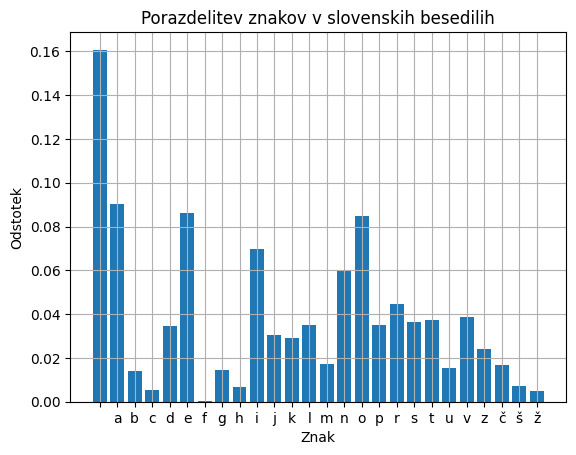

In [65]:
import matplotlib.pyplot as plt

def plot_freqs():
    stats = dict(sorted(relative_freqs_slovene.items())) # Slovar sortiramo po abecednem vrstnem redu, da bo prikaz lepši

    x = list(stats.keys())
    y = list(stats.values())

    plt.bar(x, y)

    plt.xlabel('Znak')
    plt.ylabel('Odstotek')
    plt.title('Porazdelitev znakov v slovenskih besedilih')
    plt.grid()
    
plot_freqs()

## Naloga 4: Napad s surovo silo na zamično šifro

Pri tej nalogi bomo izrabili dejstvo, da ima zamična šifra trivialno majhen prostor ključev. Zašifrirano vsebino bomo dešifrirali z vsemi možnimi ključi in kot pravi ključ izbrali tistega, pri katerem je dešifrirana vsebina *smiselna*.

V datoteki `data/ct-shift.txt` se nahaja tajnopis šifriran z zamično šifro in neznanim ključem. S tem napadom bomo ugotovili pravi ključ in prebrali vsebino.

Implementirajte funkcijo `bf_shift(ct)`, ki podani tajnopisa dešifrira z vsemi možnimi ključi. Kot rezultat na funkcija vrne seznam terk, kjer prvi element posamezne terke predstavlja šifrirni ključ, drugi element pa dešifriran tajnopis. Uporabnik se lahko nato na podlagi izpisa odloči, kateri ključ je pravi.

In [66]:
def bf_shift(ct):
    s = []
    for c in ALPHABET:
        s.append((c, dec_shift(c, ct)))
    return s

# preberemo tajnopis iz datoteke   
# dešifriramo z vsemi mogočimi ključi
for k, pt in bf_shift(load("data/ct-shift.txt")):
    print(k, pt[:50])

a oilšckfgzvfjzvtznzbfvicdcvšvtjcnkfevdcldnzčohfevpf
b nhksbjefvueivušvmvaeuhbčbusušibmjedučbkčmvcngeduoe
c mgjraideutdhutsulu dtgacatrtshalidčtcajclubmfdčtnd
č lfip hčdtščgtšrtktžčšf b špšrg khčcšb ibktalečcšmč
d kehožgcčšscfšspšjšzcsežažsospfžjgcbsažhajš kdcbslc
e jdgnzfbcsrbesrosisvbrdz zrnroezifbar zg isžjčbarkb
f ičfmveabrpadrpnrhruapčvžvpmpndvhea pžvfžhrzica pja
g hcelud apo čpompgpt ocuzuolomčugd žozuezgpvhb žoi 
h gbdktčž onžconlofošžnbtvtnknlctfčžznvtdvfougažznhž
i fačjšczžnmzbnmknenszmašušmjmkbšeczvmuščuentf zvmgz
j e cisbvzmlvamljmdmrvl stsliljasdbvultsctdmšežvulfv
k džbhrauvlku lkilčlpukžršrkhki rčautkšrbščlsdzutkeu
l čzagp tukjtžkjhkckotjzpspjgjhžpc tšjspasckrčvtšjdt
m cv fožštjišzjigjbjnšivoroifigzobžšsiro rbjpcušsičš
n buženzsšihsvihfiaimshunpnhehfvnazsrhpnžpaiobtsrhcs
o atzdmvrshgruhgeh hlrgtmomgdgeum vrpgomzo hnašrpgbr
p  švčluprgfptgfdgžgkpfšlnlfčfdtlžupofnlvnžgm spofap
r žsucktopfeošfečfzfjoeskmkecečškztonemkumzflžrone o
s zrtbjšnoednsedceveindrjljdbdcsjvšnmdljtlvekz

## Naloga 5: Avtomatiziran napad s surovo silo na zamično šifro

Sedaj bomo pristop iz naloge 4 izboljšali, in sicer tako, da bo algoritem ne bo več
potreboval pomoči uporabnika, temveč bo samodejno ugotovil, kateri ključ je pravi.

To bomo naredili tako, da bomo primerjali porazdelitev znakov v običajni Slovenščini s porazdelitvijo 
znakov v dešifriranemu besedilu. Tisto dešifrirano besedilo, katerega porazdelitev znakov je najbolj
podobna porazdelitvi znakov v običajni Slovenščini, je z veliko verjetnostjo bilo dešifrirano s pravim
ključem.

### Naloga 5.1: Implementacija funkcije `chi_sqr(freqs, rel_freqs)`

Naloga bo lažje rešljiva s pomočjo pomožne funkcije `chi_sqr(freqs, rel_freqs)`, ki vzame dva slovarja.
Prvi, `freqs`, ponazarja **absolutne** frekvence črk v dešifriranem besedilu, drugi, `rel_freqs`, pa
**relativne** frekvence črk v ciljnem jeziku, npr. Slovenščini. Funkcija na izhodu vrne vrednost
statistike $\chi^2$.

Podrobnosti izračuna omenjene statistike poiščite v prosojnicah s predavanj. Primer:
```python
>>> f = {"a": 340, "b": 620, "c": 100}
>>> p = {"a": 0.3, "b": 0.5, "c": 0.2}
>>> chi_sqr(f, p)
75.9748427672956
```

Predpostavite, da podana slovarja vsebujeta iste ključe.

In [67]:
def chi_sqr(f, p):
    print(f)
    return sum((f.get(c, 0) - p.get(c, 0)*sum(f.values()))**2 / (p.get(c, 0)*sum(f.values()) + 1e-10) for c in ALPHABET)

#(x -m)**2 / m

In [68]:
assert abs(chi_sqr({"a": 340, "b": 620, "c": 100}, {"a": 0.3, "b": 0.5, "c": 0.2}) - 75.9748427672956) < 0.00001

{'a': 340, 'b': 620, 'c': 100}


### Naloga 5.2: Avtomatizirano iskanje pravega ključa

Implementirajte funkcijo `bf_shift_auto(ct, rel_freq)`, ki iz tajnopisa ter relativnih frekvenc ciljnega jezika
ugotovi najbolj verjeten ključ, ki je bil uporabljen za šifriranje tajnopisa.

Pri izdelavi statistike nad dešifriranim besedilom si pomagajte z razredom `Counter`.

Funkcija naj vrne par `(k, pt)`, kjer `k` predstavlja ključ, `pt` pa prvih 50 znakov dešifriranega besedila.

In [69]:
def bf_shift_auto(ct, rel_freqs):

    best_key = None
    best_pt = None
    best_r = float('inf')
    
    for c in ALPHABET:
        pt = dec_shift(c, ct)
        result = chi_sqr(Counter(pt), rel_freqs)
        
        if result < best_r:
            best_r = result
            best_key = c
            best_pt = pt
            
    return best_key, best_pt
        

bf_shift_auto(load("data/ct-shift.txt"), relative_freqs_slovene)

Counter({'v': 697, 'c': 430, 'l': 359, 'f': 351, 'k': 350, 'z': 350, 'o': 207, 'n': 195, 'g': 183, 'm': 169, 'b': 159, 'i': 151, 'š': 143, 'r': 139, 'h': 136, 'j': 131, 't': 107, 's': 71, 'e': 63, 'd': 59, 'ž': 53, 'a': 50, ' ': 33, 'p': 28, 'u': 21, 'č': 3})
Counter({'u': 697, 'b': 430, 'k': 359, 'e': 351, 'j': 350, 'v': 350, 'n': 207, 'm': 195, 'f': 183, 'l': 169, 'a': 159, 'h': 151, 's': 143, 'p': 139, 'g': 136, 'i': 131, 'š': 107, 'r': 71, 'd': 63, 'č': 59, 'z': 53, ' ': 50, 'ž': 33, 'o': 28, 't': 21, 'c': 3})
Counter({'t': 697, 'a': 430, 'j': 359, 'd': 351, 'i': 350, 'u': 350, 'm': 207, 'l': 195, 'e': 183, 'k': 169, ' ': 159, 'g': 151, 'r': 143, 'o': 139, 'f': 136, 'h': 131, 's': 107, 'p': 71, 'č': 63, 'c': 59, 'v': 53, 'ž': 50, 'z': 33, 'n': 28, 'š': 21, 'b': 3})
Counter({'š': 697, ' ': 430, 'i': 359, 'č': 351, 'h': 350, 't': 350, 'l': 207, 'k': 195, 'd': 183, 'j': 169, 'ž': 159, 'f': 151, 'p': 143, 'n': 139, 'e': 136, 'g': 131, 'r': 107, 'o': 71, 'c': 63, 'b': 59, 'u': 53, 'z': 

('z',
 'slovenija ima zaradi lege v zmernih geografskih širinah na prehodu alp v dinaride in sredozemlja v panonsko kotlino izrazito prehodno podnebje ki je posledica sovplivanja morskih in celinskih zračnih gmot na lokalne podnebne razmere ima precejšen vpliv tudi velika reliefna pestrost in višinska razčlenjenost površja na slovenskem ozemlju prihaja do stika in prepletanja gorskega alpskega sredozemskega in celinskega podnebja za vse tri podnebne tipe je značilna netipičnost če jih primerjamo s pravim gorskim sredozemskim ali celinskim podnebjem s prepletanjem njihovih glavnih značilnosti zato jim pogosto dodajamo predpono sub submediteransko subkontinentalno submontansko podnebje ali jih označujemo za zmerno sredozemsko gorsko celinsko izrazita prehodnost podnebnih tipov otežuje podnebno členitev in določanje meja med tipi in podtipi podnebij pa tudi poimenovanje na splošno se z oddaljevanjem od alp in visokih dinarskih planot proti vzhodu in severovzhodu slovenije krepijo celinske

## Naloga 6: Napad na Vigenerjevo šifro

Na koncu implementirajmo še celoten napad na Vigenerjevo šifro. Implementacija bo potekala v dveh delih.

### Naloga 6.1: Napad, ko je dolžina ključa znana

Denimo, da je dolžina ključa $q$. Torej vemo, da se vsaki $q$-ti znak šifrira z isto zamično šifro. 

Pri napadu moramo tajnopis razdeliti v $q$ pod-tajnopisov, nato pa vsakega od teh razbiti z avtomatiziranim napadom na zamično šifro. Ko je znan ključ za vsakega od pod-tajnopisov, ključe združimo v celoto in cel tajnopis dešifriramo s Vigenerjevim dešifriranim algoritmom in sestavljenim ključem. Podrobnosti poiščite na prosojnicah s predavanj.

Funkcija `bf_vigenere(klen, ct, rel_freqs)` vzame kot prvi argument `klen` dolžino ključa, `ct` predstavlja tajnopis, `rel_freqs` pa relativne frekvence znakov v ciljnem jeziku (v Slovenščini v našem primeru).

Tajnopis je shranjen v datoteki `data/ct-vigenere.txt`, dolžina ključa pa je 26.

In [70]:
def bf_vigenere(klen, ct, rel_freqs):
    key = ""
    sts = ["" for _ in range(klen)]
    for i, c in enumerate(ct):
        sts[i % klen] += c
    
    for st in sts:
        k, _ = bf_shift_auto(st, rel_freqs)
        key += k
        
    pt = dec_vigenere(key, ct)
    
    return key, pt


# dešifriraj tajnopis
bf_vigenere(26, load("data/ct-vigenere.txt"), relative_freqs_slovene)

Counter({'t': 60, 'a': 55, 'u': 36, 'i': 34, 'd': 32, 'j': 28, 'l': 23, 'm': 21, 'o': 18, 'g': 18, 'k': 17, 'e': 15, 'r': 14, 'h': 12, 'p': 11, 'v': 10, 'f': 10, ' ': 9, 's': 7, 'b': 4, 'ž': 4, 'č': 4, 'z': 4, 'n': 2, 'c': 2})
Counter({'š': 60, ' ': 55, 't': 36, 'h': 34, 'č': 32, 'i': 28, 'k': 23, 'l': 21, 'n': 18, 'f': 18, 'j': 17, 'd': 15, 'p': 14, 'g': 12, 'o': 11, 'u': 10, 'e': 10, 'ž': 9, 'r': 7, 'a': 4, 'z': 4, 'c': 4, 'v': 4, 'm': 2, 'b': 2})
Counter({'s': 60, 'ž': 55, 'š': 36, 'g': 34, 'c': 32, 'h': 28, 'j': 23, 'k': 21, 'm': 18, 'e': 18, 'i': 17, 'č': 15, 'o': 14, 'f': 12, 'n': 11, 't': 10, 'd': 10, 'z': 9, 'p': 7, ' ': 4, 'v': 4, 'b': 4, 'u': 4, 'l': 2, 'a': 2})
Counter({'r': 60, 'z': 55, 's': 36, 'f': 34, 'b': 32, 'g': 28, 'i': 23, 'j': 21, 'l': 18, 'd': 18, 'h': 17, 'c': 15, 'n': 14, 'e': 12, 'm': 11, 'š': 10, 'č': 10, 'v': 9, 'o': 7, 'ž': 4, 'u': 4, 'a': 4, 't': 4, 'k': 2, ' ': 2})
Counter({'p': 60, 'v': 55, 'r': 36, 'e': 34, 'a': 32, 'f': 28, 'h': 23, 'i': 21, 'k': 18, 'č

('unzožlmrčsfb tcpvihšjegkda',
 'france prešeren izgovorjava  franc prešrn slovenski pesnik   december  vrba   februar  kranj france prešeren se je rodil v kmečki družini v osnovni šoli je bil tako priden da so ga zapisali v zlato knjigo po uspešno zaključenem študiju na dunajski pravni fakulteti se je vrnil v ljubljano kjer je delal kot odvetnik v tem času je napisal večino svojih pesmi pri pisanju katerih ga je pomembno usmerjal prijatelj matija čop prešeren je prvi slovenec ki se je po kakovosti svojega pisanja lahko kosal s sodobniki po evropi kjer je tedaj vladala romantična usmeritev življenjska pot pesnika nesrečno zaljubljenega v bogato primičevo julijo ki ji je posvetil sonetni venec  in nekatere druge ljubezenske pesmi je bila polna raznovrstnih preizkušenj njegovi prijatelji so umirali eden za drugim kot pesnik pa v času svojega življenja ni bil priznan v zadnjih letih življenja se je vse bolj soočal z malodušjem težavami z alkoholom ki je nazadnje povzročil njegovo smrt fra

### Naloga 6.2: Napad, ko dolžina ključa ni znana

Na koncu ostane še primer, ko napadalec dolžine ključa ne pozna. V tem primeru mora napadalec le preskusiti vse ključe od dolžine 1 pa do neke zgornje meje $q_\max$, katero si zastavi sam.

Ko najde ključ, ki tajnopis dešifrira v neko smisleno besedilo, je naloga končana. Pri ugotavljanju, ali je vsebina smiselna, uporabite statistiko $\chi^2$ oz. funkcijo `chi_sqr(f, p)`.

Funkcija `break_vigenere(ct, rel_freqs, max_klen=30)` na vhodu vzame tajnopis `ct`, relativne frekvence znakov ciljnega jezika `rel_freqs` ter opcijski argument `max_klen`, ki podaja zgornjo mejo dolžine ključa t. i. $q_\max$. Funkcija naj vrne par `(k, pt)`, ki predstavlja ključ in dešifriran tajnopis.

Primer tajnopisa šifriranega z neznano dolžino ključa se nahaja v datoteki `data/ct-vigenere-2.txt`.

In [71]:
def break_vigenere(ct, rel_freqs, max_klen=30):
    best_key = None
    best_pt = None
    best_r = float('inf')
    
    for klen in range(1, max_klen + 1):
        key, pt = bf_vigenere(klen, ct, rel_freqs)
        result = chi_sqr(Counter(pt), rel_freqs)
        
        if result < best_r:
            best_r = result
            best_key = key
            best_pt = pt
            
    return best_key, best_pt

break_vigenere(load("data/ct-vigenere-2.txt"), relative_freqs_slovene)

Counter({'ž': 6007, 'š': 5738, 'n': 5727, 'k': 5715, 'i': 5642, 'd': 5578, 'b': 5528, 'č': 5415, 'j': 5381, 'z': 5371, 't': 5359, 'v': 5291, 'f': 5236, 'l': 5176, 's': 5152, 'm': 5098, 'u': 5030, 'e': 4781, 'h': 4763, 'r': 4661, 'g': 4399, 'c': 4389, ' ': 4214, 'o': 4024, 'p': 3876, 'a': 3778})
Counter({'z': 6007, 's': 5738, 'm': 5727, 'j': 5715, 'h': 5642, 'č': 5578, 'a': 5528, 'c': 5415, 'i': 5381, 'v': 5371, 'š': 5359, 'u': 5291, 'e': 5236, 'k': 5176, 'r': 5152, 'l': 5098, 't': 5030, 'd': 4781, 'g': 4763, 'p': 4661, 'f': 4399, 'b': 4389, 'ž': 4214, 'n': 4024, 'o': 3876, ' ': 3778})
Counter({'v': 6007, 'r': 5738, 'l': 5727, 'i': 5715, 'g': 5642, 'c': 5578, ' ': 5528, 'b': 5415, 'h': 5381, 'u': 5371, 's': 5359, 't': 5291, 'd': 5236, 'j': 5176, 'p': 5152, 'k': 5098, 'š': 5030, 'č': 4781, 'f': 4763, 'o': 4661, 'e': 4399, 'a': 4389, 'z': 4214, 'm': 4024, 'n': 3876, 'ž': 3778})
Counter({'u': 6007, 'p': 5738, 'k': 5727, 'h': 5715, 'f': 5642, 'b': 5578, 'ž': 5528, 'a': 5415, 'g': 5381, 't':

('kzslfgšjiucžmen dvto',
 'the project gutenberg ebook of za narodov blagor b ivan cankar this ebook is for the use of anone anhere at no cost and ith almost no restrictions hatsoever ou ma cop it give it aa or reuse it under the terms of the project gutenberg license included ith this ebook or online at gutenbergorg title za narodov blagor komedija v stirih dejanjih author ivan cankar release date october   ebook  language slovenian character set encoding utf  start of this project gutenberg ebook za narodov blagor  produced b peter podgorsek mariano cecoski and the online distributed proofreading team at httpspgdpnet this book as produced from scanned images of public domain material from the google print project za narodov blagor vse pravice za prevajanje uprizoritev itd pridržuje si izključno založnik  l schentner v ljubljani      napram gledališkim odrom  rokopis za narodov blagor komedija v štirih dejanjih spisal ivan cankar ljubljana  založil l schentner osebe aleksij pl gornik 